In [91]:
using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

  Activating project at `~/Projects/ASTRAL/mast`


In [92]:
# list of me2 format
#=
PSL me2 met file header
1           PSD timecode: MMSSsss
2           PSMV Lat
3           PSMV Lon
4           PSMV SOG knots
5           PSMV COG
6           Gyro Heading
7           Wind Speed, Relative, Bow Sonic
8           Wind Dir, Relative, Bow Sonic
9           Wind Speed, True, Bow Sonic
10          Wind Dir, True, Bow Sonic
11          Air Temperature
12          Relative Humidity
13          Barometric Pressure
14          Intake Sea Temperature
15          TSG Sea Temperature (bow)
16          TSG Salinity (bow)
17          ROSR Radiometric Sea Surface Temperature
18          PIR Longwave Radiation
19          PSP Shortwave Radiation
20          PIR Thermopile Raw
21          PIR Case Temperature
22          PIR Dome Temperature
=#

In [106]:
# utility functions

m2n(x) = ismissing(x) ? NaN : x

pd = permutedims

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))

mastdir = "./data/PSL/"

"return all filenames with prefix and date dt"
function get_psl_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_psl_filenames(prefix, dt::Date, mastdir=mastdir)
    get_psl_filenames(prefix, yday(dt), mastdir=mastdir)
end
"return filenames with prefix matching hour of dt"
function get_psl_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_psl_filenames(prefix, Date(dt), mastdir=mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_psl_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath(mastdir,@sprintf("%03d",yday(dt)), get_psl_filenames(prefix, dt, mastdir=mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(dt, hr::Integer, psltime::String)
    # mm  = map(t -> Minute(     parse(Int32, t[1:2])), psltime)
    # SS  = map(t -> Second(     parse(Int32, t[3:4])), psltime)
    # sss = map(t -> Millisecond(parse(Int32, t[5:7])), psltime)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    datatime = DateTime(Date(dt)) + Hour(hr) + mm + SS + sss
end
# psldatetime(Date(2024,5,8), "0606111")

psldatetime

In [107]:
# readers

# file format default parameters
nheader = 1
nsample = countlines(joinpath(mastdir,string(yday(dt)),filename)) - nheader
ncolumn = 22

"read mean met 1 data and put in a dictionary"
function read_me2_dict(filename;
    nheader=nheader,
    nsample=countlines(joinpath(mastdir,string(yday(dt)),filename)) - nheader,
    ncolumn=ncolumn )

    # read data from file
    datatime, X = read_me2_data(filename; nheader=nheader,
        nsample=countlines(joinpath(mastdir,string(yday(dt)),filename)) - nheader,
        ncolumn=ncolumn )
    
    return me2_dict(datatime, X) # return dict
end

"read me2 file data"
function read_me2_data(filename;
    nheader=nheader,
    nsample=countlines(joinpath(mastdir,string(yday(dt)),filename)) - nheader,
    ncolumn=ncolumn )

    # preallocate the data
    psltime = Vector{String}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn-1)
    fill!(X, missing)

    open(joinpath(mastdir,string(yday(dt)),filename)) do file
        for _ in 1:nheader
            readline(file) # skip header
        end
        nl = 0
        for line in readlines(file)
            nl += 1
            splt = split(line, [' ',',','\t'])
            psltime[nl] = splt[1]
            X[nl,:] .= parse.(Float32, splt[2:end])
        end
    end

    hr = parse(Int32, filename[9:10])
    psldt = psldatetime.(dt, hr, psltime)
    return psldt, X
end

"allocate and fill the dictionary with the named keys"
function me2_dict(datatime::Vector, X::Matrix)
    # allocate mean met 1 dictionary
    Me2 = Dict(
        :time      => Vector{DateTime}(missing, nsample),
        :Batt_Volt => Vector{Union{Float32,Missing}}(missing, nsample),
        :PTemp     => Vector{Union{Float32,Missing}}(missing, nsample),
        :Case1_R   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Case1_T   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Dome1_R   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Dome1_T   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Case2_R   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Case2_T   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Dome2_R   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Dome2_T   => Vector{Union{Float32,Missing}}(missing, nsample),
        :PIR1_V    => Vector{Union{Float32,Missing}}(missing, nsample),
        :PIR1_wm2  => Vector{Union{Float32,Missing}}(missing, nsample),
        :PSP1_V    => Vector{Union{Float32,Missing}}(missing, nsample),
        :PSP1_wm2  => Vector{Union{Float32,Missing}}(missing, nsample),
        :PIR2_V    => Vector{Union{Float32,Missing}}(missing, nsample),
        :PIR2_wm2  => Vector{Union{Float32,Missing}}(missing, nsample),
        :PSP2_V    => Vector{Union{Float32,Missing}}(missing, nsample),
        :PSP2_wm2  => Vector{Union{Float32,Missing}}(missing, nsample),
        :Snake_R   => Vector{Union{Float32,Missing}}(missing, nsample),
        :Snake_C   => Vector{Union{Float32,Missing}}(missing, nsample),
        :BP_hpa    => Vector{Union{Float32,Missing}}(missing, nsample) )
    fill_me1_dict!(Me1, datatime, X)
    return Me1
end

"assign data to the dict keys"
function fill_me1_dict!(Me1, datatime, X)
    keys = Symbol.(split(
    """time
    Batt_Volt
    PTemp
    Case1_R
    Case1_T
    Dome1_R
    Dome1_T
    Case2_R
    Case2_T
    Dome2_R
    Dome2_T
    PIR1_V
    PIR1_wm2
    PSP1_V
    PSP1_wm2
    PIR2_V
    PIR2_wm2
    PSP2_V
    PSP2_wm2
    Snake_R
    Snake_C
    BP_hpa"""))

    # fill mean met 1 dictionary
    Me1[:time] = datatime
    for (ik, key) in enumerate(keys)
        Me1[key] .= X[:,ik+1]
    end
end

fill_me1_dict!

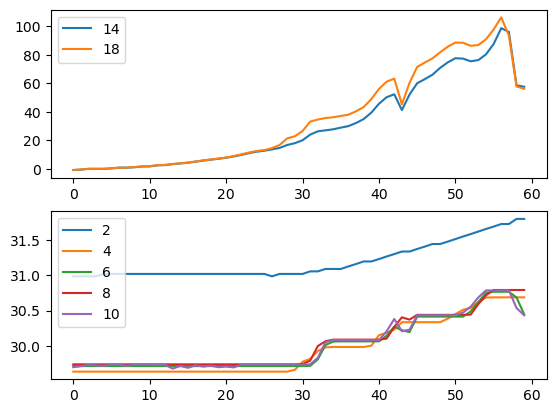

PyObject <matplotlib.legend.Legend object at 0x33e244ac0>

In [109]:
# read an example file
# mastdir = "./data/PSL/"
prefix = "me2" # me1???
dt = Date(2024,05,08) # for datestamp in filter(startswith("2024"), readdir(mastdir))
filename = filter(startswith("me2"), readdir(joinpath(mastdir, string(yday(dt)))))[1]
filename
datatime, ME1 = read_me1_data(filename)

subplot(2,1,1)
plot(m2n(ME1[:,[14,18]])) # shortwave
legend([14,18])

subplot(2,1,2)
idx = [2,4,6,8,10] # temperatures
plot(m2n(ME1[:,idx])) 
legend(idx)
# 12 is 40
# 13,15 are very small

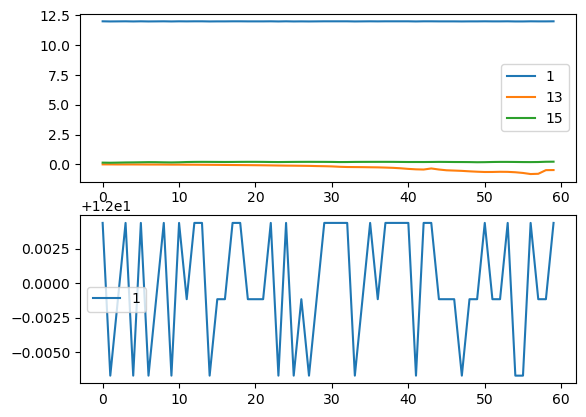

PyObject <matplotlib.legend.Legend object at 0x33e2fd030>

In [110]:
subplot(2,1,1)
idx = [1,13,15]
plot(m2n(ME1[:,idx])) # longwave thermopile differences?
legend(idx)

subplot(2,1,2)
idx = [1] # temperatures
plot(m2n(ME1[:,idx])) 
legend(idx)
# 3,5,7 are 8000